# Network continuity with OSM data

## Preparation

Set the coordinates and buffer distances to your preferred extents.


In [1]:
from cityseer.tools import io

# lng, lat, buffer_dist, plot_buffer = -1.7063649924889566, 52.19277374082795, 1500, 1250  # stratford-upon-avon
lng, lat, buffer_dist, plot_buffer = -0.13039709427587876, 51.516434828344366, 6000, 5000  # london
# lng, lat, buffer_dist, plot_buffer = 18.425702641104582, -33.9204746754594, 3000, 2500  # cape town
poly_wgs, poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer_dist)
# select extents for plotting
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U


## Loading data from OSM

For this example, we'll use a custom OSM query that excludes footways because the continuity analysis needs OSM ways that have street name or route number information.

For this form of analysis, only basic cleaning is recommended:
- not consolidating nodes because this risks accidentally dropping highway / ref / name attributes
- not like closeness or betweenness methods, where topological distortions are arguably a bigger issue

In [2]:
query = """
[out:json];
(
    way["highway"]
    ["area"!="yes"]
    ["highway"!~"footway|pedestrian|steps|bus_guideway|escape|raceway|proposed|planned|abandoned|platform|construction"]
    ["service"!~"parking_aisle"]
    ["amenity"!~"charging_station|parking|fuel|motorcycle_parking|parking_entrance|parking_space"]
    ["access"!~"private|customers"]
    ["indoor"!="yes"]
    (poly:"{geom_osm}");
);
out body;
>;
out qt;
"""
G_osm = io.osm_graph_from_poly_wgs(
    poly_wgs, custom_request=query, simplify=True, remove_parallel=False, iron_edges=False
)

INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 130404/130404 [00:07<00:00, 17352.60it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 140438/140438 [00:00<00:00, 991345.52it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 140438/140438 [00:01<00:00, 100098.28it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 130404/130404 [00:21<00:00, 5934.80it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 35275/35275 [00:00<00:00, 332965.17it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 32319/32319 [00:00<00:00, 49253.48it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 30148/30148 [00:04<00:00, 7296.07it/s]
INFO:cityseer.tools.graphs:

## Observe continuity metrics

We can now run the contunity metrics

In [3]:
import matplotlib.pyplot as plt

from cityseer.tools import io, plot
from cityseer.metrics import observe

# methods can be "names", "routes", "highways"

print("Continuity by street names")
G_cont, NamesContReport = observe.street_continuity(G_osm, method="names")
NamesContReport.report_by_count(n_items=5)
NamesContReport.report_by_length(n_items=5)

print("Continuity by route numbers")
G_cont, RoutesContReport = observe.street_continuity(G_cont, method="routes")
RoutesContReport.report_by_count(n_items=5)
RoutesContReport.report_by_length(n_items=5)

print("Continuity by highway types")
G_cont, HwyContReport = observe.street_continuity(G_cont, method="highways")
HwyContReport.report_by_count(n_items=5)
HwyContReport.report_by_length(n_items=5)

print("Continuity by overlapping routes and names types")
G_cont, HybridContReport = observe.hybrid_street_continuity(G_cont, RoutesContReport, NamesContReport)
HybridContReport.report_by_count(n_items=5)
HybridContReport.report_by_length(n_items=5)

INFO:cityseer.metrics.observe:Calculating metrics for names.


Continuity by street names


100%|██████████| 34912/34912 [00:00<00:00, 42875.33it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 68 - holloway road
INFO:cityseer.metrics.observe:Count: 62 - finchley road
INFO:cityseer.metrics.observe:Count: 60 - wandsworth road
INFO:cityseer.metrics.observe:Count: 60 - battersea park road
INFO:cityseer.metrics.observe:Count: 58 - king's road
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 5.06km - finchley road
INFO:cityseer.metrics.observe:Length: 4.98km - regent's canal towpath
INFO:cityseer.metrics.observe:Length: 4.55km - victoria embankment
INFO:cityseer.metrics.observe:Length: 4.51km - outer circle
INFO:cityseer.metrics.observe:Length: 4.49km - westway


Continuity by route numbers


INFO:cityseer.metrics.observe:Calculating metrics for routes.
100%|██████████| 34912/34912 [00:00<00:00, 151448.89it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 193 - a501
INFO:cityseer.metrics.observe:Count: 189 - a4
INFO:cityseer.metrics.observe:Count: 176 - a3220
INFO:cityseer.metrics.observe:Count: 151 - a3
INFO:cityseer.metrics.observe:Count: 147 - a400
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 14.52km - a4
INFO:cityseer.metrics.observe:Length: 11.42km - a501
INFO:cityseer.metrics.observe:Length: 11.03km - a3220
INFO:cityseer.metrics.observe:Length: 8.28km - a400
INFO:cityseer.metrics.observe:Length: 8.12km - a3


Continuity by highway types


INFO:cityseer.metrics.observe:Calculating metrics for highways.
100%|██████████| 34912/34912 [00:00<00:00, 144086.96it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 14397 - residential
INFO:cityseer.metrics.observe:Count: 6705 - service
INFO:cityseer.metrics.observe:Count: 3597 - unclassified
INFO:cityseer.metrics.observe:Count: 3303 - primary
INFO:cityseer.metrics.observe:Count: 2256 - tertiary
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 1043.54km - residential
INFO:cityseer.metrics.observe:Length: 400.62km - service
INFO:cityseer.metrics.observe:Length: 247.03km - unclassified
INFO:cityseer.metrics.observe:Length: 193.19km - primary
INFO:cityseer.metrics.observe:Length: 156.58km - cycleway


Continuity by overlapping routes and names types


INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 226 - a501
INFO:cityseer.metrics.observe:Count: 209 - a3220
INFO:cityseer.metrics.observe:Count: 201 - a4
INFO:cityseer.metrics.observe:Count: 171 - a400
INFO:cityseer.metrics.observe:Count: 167 - a3
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 15.09km - a4
INFO:cityseer.metrics.observe:Length: 13.43km - a3220
INFO:cityseer.metrics.observe:Length: 13.28km - a501
INFO:cityseer.metrics.observe:Length: 9.89km - a202
INFO:cityseer.metrics.observe:Length: 9.7km - a400


INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: names


100%|██████████| 34912/34912 [00:00<00:00, 732124.76it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:04<00:00, 8605.94it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
100%|██████████| 34912/34912 [00:00<00:00, 775217.14it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:03<00:00, 8907.42it/s]


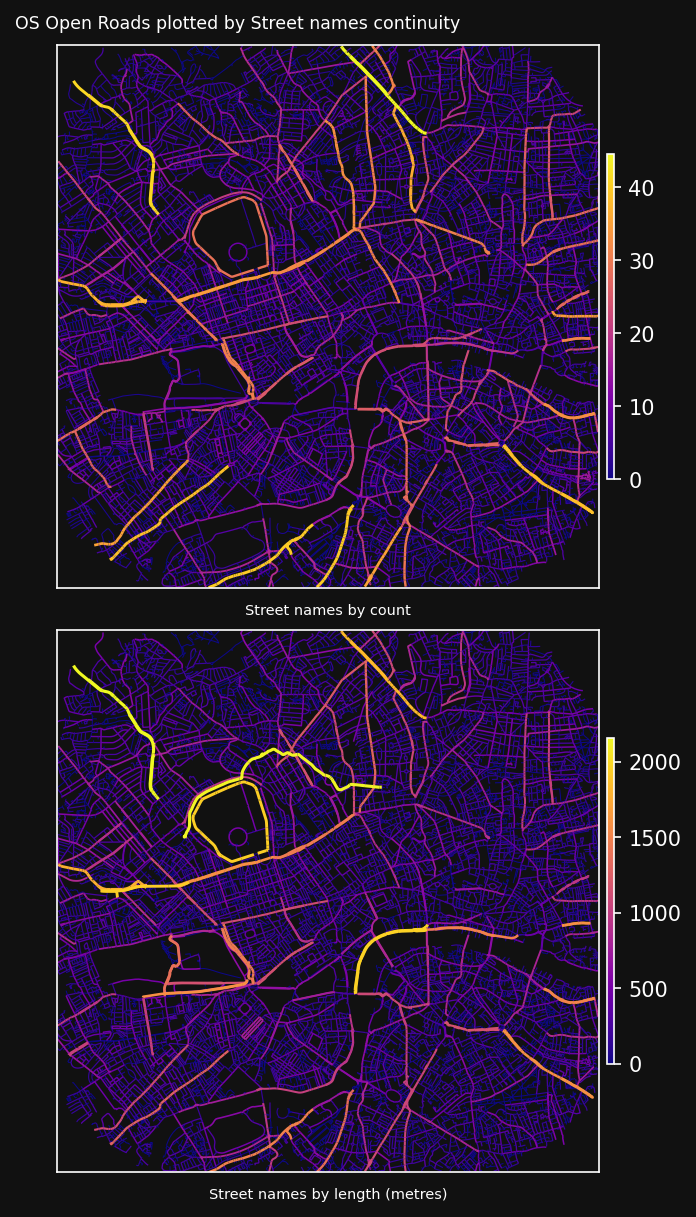

INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: routes


100%|██████████| 34912/34912 [00:00<00:00, 567610.31it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:04<00:00, 8514.39it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
100%|██████████| 34912/34912 [00:00<00:00, 778191.63it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:03<00:00, 8768.94it/s]


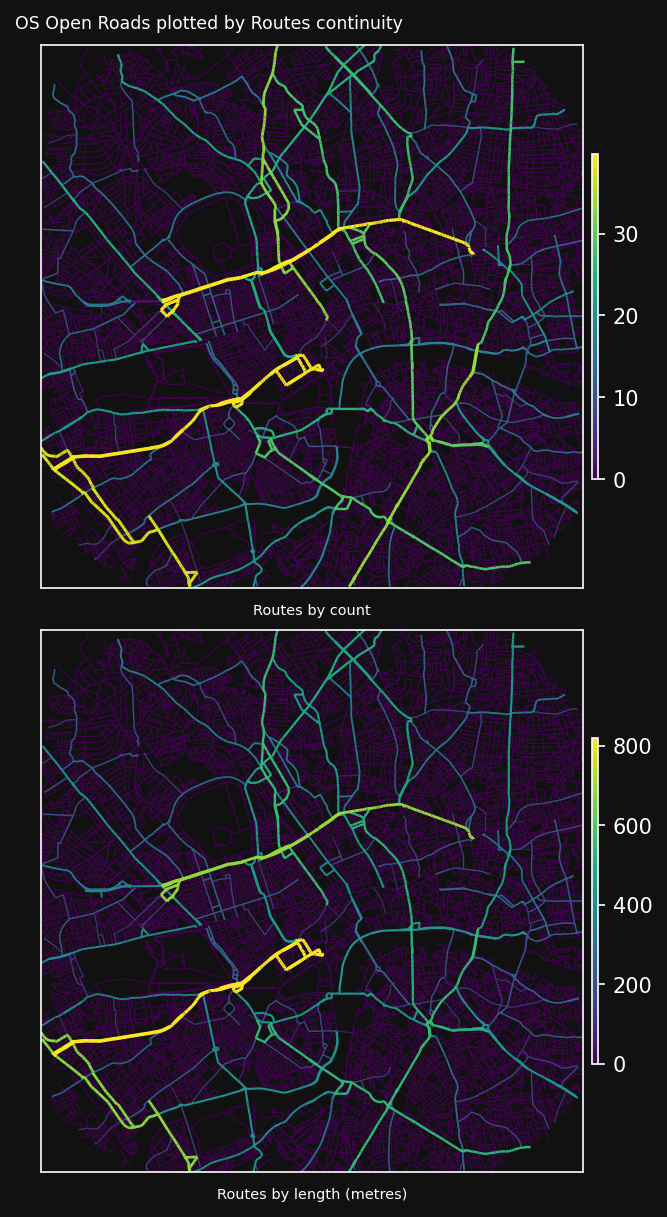

INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: highways


100%|██████████| 34912/34912 [00:00<00:00, 607554.38it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:04<00:00, 8276.93it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
100%|██████████| 34912/34912 [00:00<00:00, 770720.72it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:03<00:00, 8769.96it/s]


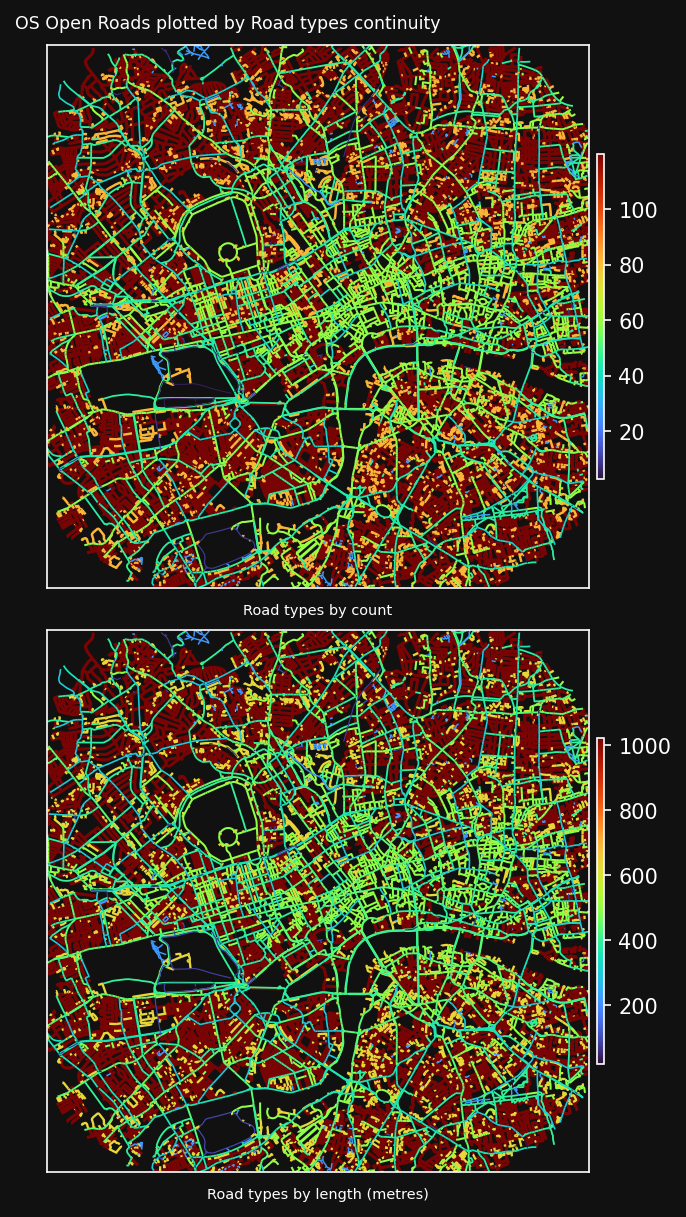

INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: hybrid


100%|██████████| 34912/34912 [00:00<00:00, 771894.85it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:04<00:00, 7908.42it/s] 
INFO:cityseer.tools.plot:Extracting edge geometries
100%|██████████| 34912/34912 [00:00<00:00, 785560.08it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 34912/34912 [00:03<00:00, 8873.50it/s] 


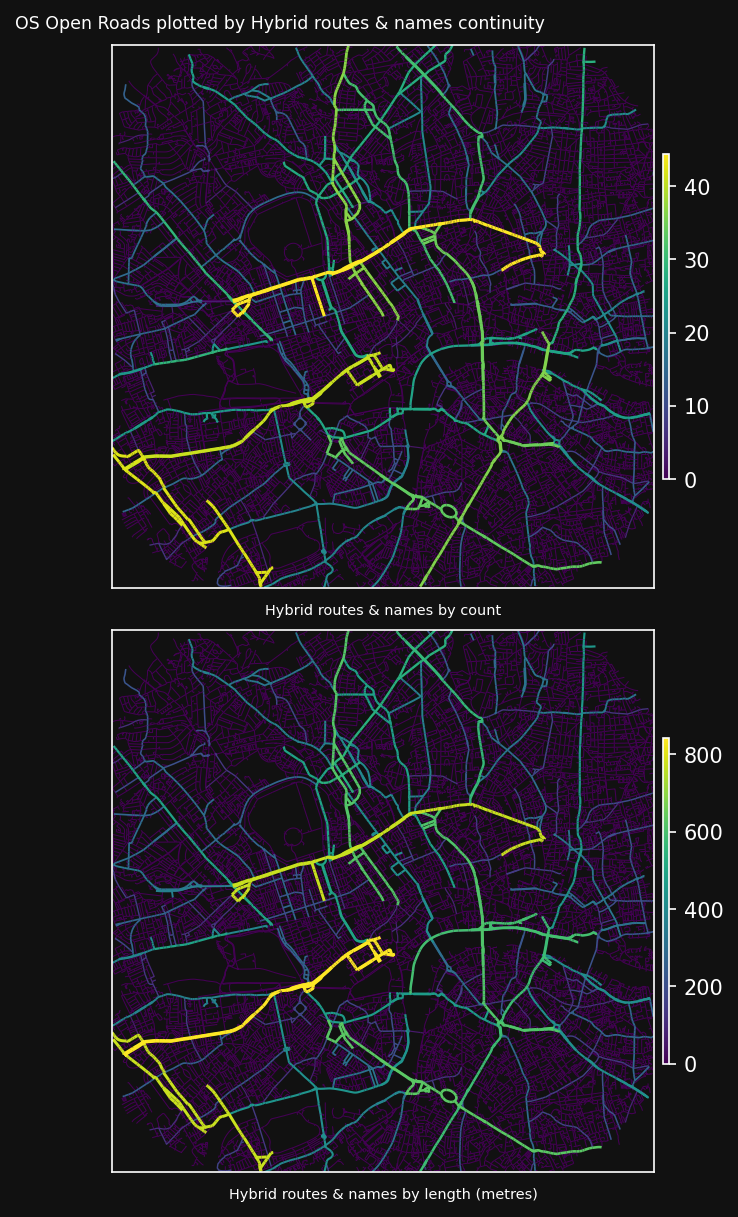

In [5]:
for method, shape_exp, descriptor, cmap, inverse in zip(
    ["names", "routes", "highways", "hybrid"],  # 
    [0.9, 0.7, 0.5, 0.7],  # 0.8, 0.8, 0.8, 
    ["Street names", "Routes", "Road types", "Hybrid routes & names"],  # "Street names", "Routes", "Road types", 
    ['plasma', 'viridis', 'turbo', 'viridis'],  # 
    [False, False, True, False]  # 
):
    print(f"Plotting results for method: {method}")
    # plot
    bg_colour = "#111"
    fig, axes = plt.subplots(2, 1, dpi=150, figsize=(6, 8), facecolor=bg_colour, constrained_layout=True)
    fig.suptitle(f"OS Open Roads plotted by {descriptor} continuity", fontsize="small", ha="center")
    # by count
    plot.plot_nx_edges(
        axes[0],  # type: ignore
        nx_multigraph=G_cont,
        edge_metrics_key=f"{method}_cont_by_count",
        bbox_extents=plot_bbox,
        cmap_key=cmap,
        lw_min=0.5,
        lw_max=1.5,
        shape_exp=shape_exp,
        face_colour=bg_colour,
        invert_plot_order=inverse,
    )
    axes[0].set_xlabel(f"{descriptor} by count", fontsize="x-small")  # type: ignore
    # by length
    plot.plot_nx_edges(
        axes[1],  # type: ignore
        nx_multigraph=G_cont,
        edge_metrics_key=f"{method}_cont_by_length",
        bbox_extents=plot_bbox,
        cmap_key=cmap,
        lw_min=0.5,
        lw_max=1.5,
        shape_exp=shape_exp,
        face_colour=bg_colour,
        invert_plot_order=inverse,
    )
    axes[1].set_xlabel(f"{descriptor} by length (metres)", fontsize="x-small")  # type: ignore
    plt.show()